In [84]:
# import the required libraries:
import os, sys
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [85]:
#Execute this script to set values for different parameters:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 200

In [86]:
file_path = '../input/english-french/fra.txt'
lines = open(file_path, encoding='UTF-8').read().strip().split('\n')
lines[750:760]

['Run away.\tFuis.\tCC-BY 2.0 (France) Attribution: tatoeba.org #8908078 (CK) & #8304670 (Micsmithel)',
 'Run away.\tEnfuyez-vous.\tCC-BY 2.0 (France) Attribution: tatoeba.org #8908078 (CK) & #9025599 (Micsmithel)',
 'Run away.\tEnfuis-toi.\tCC-BY 2.0 (France) Attribution: tatoeba.org #8908078 (CK) & #9025600 (Micsmithel)',
 'Save Tom.\tSauve Tom.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2203865 (CK) & #6465319 (Aiji)',
 'Save Tom.\tSauvez Tom.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2203865 (CK) & #6465320 (Aiji)',
 'Say what?\tDe quoi\u202f?\tCC-BY 2.0 (France) Attribution: tatoeba.org #8453907 (shekitten) & #952623 (sacredceltic)',
 'She came.\tElle est venue.\tCC-BY 2.0 (France) Attribution: tatoeba.org #853152 (piksea) & #1006703 (elgranjuego)',
 'She died.\tElle est morte.\tCC-BY 2.0 (France) Attribution: tatoeba.org #1400268 (enteka) & #435303 (jerom)',
 'She left.\tElle est partie.\tCC-BY 2.0 (France) Attribution: tatoeba.org #3258750 (CH) & #134220 (Cocorico)',
 'Sh

The language translation model that we are going to develop will translate English sentences into their French language counterparts. To develop such a model, we need a dataset that contains English sentences and their French translations.

# Data Preprocessing

We need to generate two copies of the translated sentence: one with the start-of-sentence token and the other with the end-of-sentence token.



In [87]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open('../input/english-french/fra.txt', encoding="utf-8"):
    count += 1
    if count > NUM_SENTENCES:
        break
    if '\t' not in line:
        continue
    input_sentence = line.rstrip().split('\t')[0]
    output = line.rstrip().split('\t')[1]

    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Number of sample input:", len(input_sentences))
print("Number of sample output:", len(output_sentences))
print("Number of sample output input:", len(output_sentences_inputs))

Number of sample input: 20000
Number of sample output: 20000
Number of sample output input: 20000


In [88]:
print("English sentence: ",input_sentences[766])
print("French translation: ",output_sentences[766])

English sentence:  Sit here.
French translation:  Asseyez-vous ici. <eos>


# Tokenization


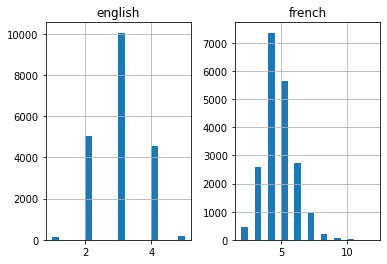

In [89]:
# let’s visualise the length of the sentences.
import pandas as pd

eng_len = []
fren_len = []

# populate the lists with sentence lengths
for i in input_sentences:
      eng_len.append(len(i.split()))  

for i in output_sentences:
      fren_len.append(len(i.split()))

length_df = pd.DataFrame({'english':eng_len, 'french':fren_len})

length_df.hist(bins = 20)
plt.show()

The histogram above shows  maximum length of the French sentences is 12 and that of the English sentence is 5.

In [90]:
#tokenize the input sentences(input language) 
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

#with open('input_tokenizer_NMT.pickle', 'wb') as handle:
#    pickle.dump(input_tokenizer, handle, protocol=4)

Total unique words in the input: 3439
Length of longest sentence in input: 5


In [91]:
#tokenize the output sentences(Output language)
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

#with open('output_tokenizer_NMT.pickle', 'wb') as handle:
#    pickle.dump(output_tokenizer, handle, protocol=4)

Total unique words in the output: 9583
Length of longest sentence in the output: 12


# Padding

In [92]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[766]:", encoder_input_sequences[766])

encoder_input_sequences.shape: (20000, 5)
encoder_input_sequences[766]: [  0   0   0 159  32]


Since there are 20,000 sentences in the input and each input sentence is of length 6, the shape of the input is now (20000, 6).

In [93]:
print(word2idx_inputs["sit"])
print(word2idx_inputs["here"])

159
32


In the same way, the decoder outputs and the decoder inputs are padded.



In [94]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[766]:", decoder_input_sequences[766])

decoder_input_sequences.shape: (20000, 12)
decoder_input_sequences[766]: [   2 1022   70    0    0    0    0    0    0    0    0    0]


In [95]:
print(word2idx_outputs["<sos>"])
print(word2idx_outputs["asseyez-vous"])
print(word2idx_outputs["ici."])

2
1022
70


In [96]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences.shape:", decoder_output_sequences.shape)


decoder_output_sequences.shape: (20000, 12)


# Word Embeddings


For English sentences, i.e. the inputs, we will use the GloVe word embeddings. For the translated French sentences in the output, we will use custom word embeddings.

In [97]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open(r'../input/glovetwitter27b100dtxt/glove.twitter.27B.200d.txt', encoding="utf8")

for line in glove_file:
    rec = line.split()
    word = rec[0]
    vector_dimensions = asarray(rec[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [98]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [99]:
print(embeddings_dictionary["join"])

[-3.7239e-01  4.7634e-01 -1.9666e-01 -1.1641e+00  1.2820e-02 -4.7063e-01
  4.4522e-01  1.8911e-01  5.6740e-01 -6.1915e-02  2.7159e-01 -1.7613e-01
 -5.4897e-01 -1.6782e-01  3.0910e-01  1.0253e-01  4.3412e-01 -4.0300e-02
  3.4782e-02  2.8017e-01  1.6735e-01 -5.3730e-02 -5.9838e-01 -6.7251e-02
 -7.0371e-01  1.0674e+00  4.1123e-01  2.6227e-01 -3.2041e-01  5.2882e-01
  3.6446e-01  1.3661e-01 -2.2680e-01  6.6556e-01  3.4684e-01 -4.1284e-01
  5.5050e-01  3.5691e-01  3.6985e-01 -3.1312e-01  9.2343e-02  1.7105e-01
 -1.5200e-01  6.4297e-02  2.2327e-01  2.9222e-01 -7.3356e-01 -4.6585e-02
 -2.1011e-01  1.2690e-01  3.1638e-01 -5.1846e-01  2.2601e-02 -1.6426e-01
 -8.4231e-02 -6.5978e-02 -1.4436e-01 -2.2150e-01  4.2886e-01  3.0813e-01
 -1.0191e-03  5.9619e-01  1.7514e-01  5.3788e-01 -6.3198e-01  1.5236e-01
 -1.9268e-01  5.8482e-03  6.8425e-01  5.9576e-01  4.4315e-01  3.5061e-01
  1.8628e-01  8.6317e-01  2.1811e-01 -2.6925e-02  1.4113e-01 -6.5218e-03
 -1.8793e-01 -7.6275e-01 -1.9529e-01 -3.8076e-01  2

In the previous section, we saw that the integer representation for the word **join** is 464. Let's now check the 464th index of the word embedding matrix.



In [100]:
print(embedding_matrix[464])

[-4.21149999e-01 -5.34840003e-02 -4.41590011e-01  1.12549996e+00
 -1.03299998e-01  1.42680004e-01  4.75450009e-01 -4.87529993e-01
  4.99509983e-02  5.11669993e-01 -4.98239994e-01 -8.81519973e-01
  3.40249985e-01  3.98400009e-01  1.13139999e+00  8.74890015e-02
  9.96380001e-02 -1.41790003e-01  2.77410001e-01 -2.94509996e-02
  8.04030001e-01 -3.60989988e-01  1.73539996e-01  1.88569993e-01
  7.69810006e-02  1.37810004e+00 -2.95960009e-01 -1.73140004e-01
 -6.99270010e-01  5.29389977e-01  5.70150018e-01 -3.40070009e-01
 -3.64399999e-01 -1.71800002e-01  4.99869995e-02  4.36259992e-02
 -1.49409994e-01 -1.35270000e-01  2.35159993e-01 -2.11689994e-01
 -6.02630004e-02  2.37639993e-01 -1.30019993e-01  7.09270000e-01
  1.34949997e-01  3.86049986e-01  2.85699993e-01  1.28030002e-01
  2.12929994e-02  5.27860001e-02 -4.55729991e-01  5.53399980e-01
  1.46750003e-01 -9.24839973e-01 -4.44669992e-01  3.26970011e-01
  2.16220006e-01 -1.79460004e-01  3.28269988e-01  3.04159999e-01
 -8.35200027e-02  3.48580

**Creates the embedding layer for the input:**

In [101]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)


# Creating the Model



In [102]:
#(number of inputs, length of the output sentence, the number of words in the output)

In [103]:
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)
decoder_targets_one_hot.shape

(20000, 12, 9584)

In [104]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

Next, we need to create the encoder and decoders. The input to the encoder will be the sentence in English and the output will be the hidden state and cell state of the LSTM.

In [105]:
encoder_inputs = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

The next step is to define the decoder. The decoder will have two inputs: the hidden state and cell state from the encoder and the input sentence, which actually will be the output sentence with an <sos> token appended at the beginning.

In [106]:
decoder_inputs = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

Finally, the output from the decoder LSTM is passed through a dense layer to predict decoder outputs.

In [107]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [108]:
#Compile
model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 5, 200)       688000      input_6[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 12, 256)      2453504     input_7[0][0]                    
____________________________________________________________________________________________

Let's plot our model to see how it looks.

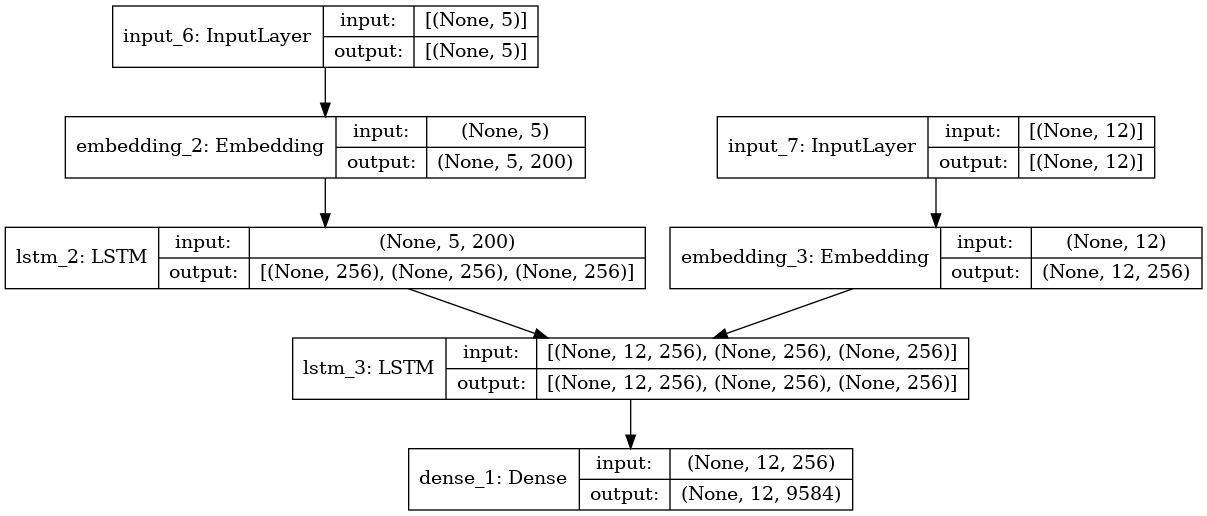

In [109]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [110]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [111]:
history = model.fit([encoder_input_sequences, decoder_input_sequences], decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_split=0.1,
)

Epoch 1/10
282/282 [==============================] - 90s 299ms/step - loss: 2.0398 - accuracy: 0.7212 - val_loss: 2.0391 - val_accuracy: 0.7146
Epoch 2/10
282/282 [==============================] - 82s 289ms/step - loss: 1.4494 - accuracy: 0.7883 - val_loss: 1.7835 - val_accuracy: 0.7440
Epoch 3/10
282/282 [==============================] - 83s 292ms/step - loss: 1.2572 - accuracy: 0.8151 - val_loss: 1.6535 - val_accuracy: 0.7624
Epoch 4/10
282/282 [==============================] - 82s 292ms/step - loss: 1.1406 - accuracy: 0.8289 - val_loss: 1.5984 - val_accuracy: 0.7690
Epoch 5/10
282/282 [==============================] - 83s 294ms/step - loss: 1.0524 - accuracy: 0.8392 - val_loss: 1.5499 - val_accuracy: 0.7759
Epoch 6/10
282/282 [==============================] - 83s 293ms/step - loss: 0.9767 - accuracy: 0.8478 - val_loss: 1.5355 - val_accuracy: 0.7757
Epoch 7/10
282/282 [==============================] - 82s 290ms/step - loss: 0.9162 - accuracy: 0.8563 - val_loss: 1.5236 - val_ac

In [112]:
model.save('seq2seq_eng-fra.h5')

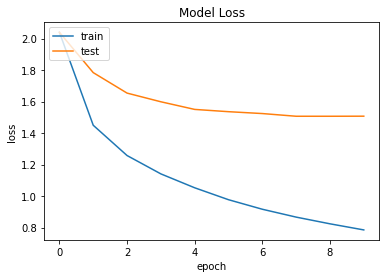

In [113]:
import matplotlib.pyplot as plt
# %matplotlib inline
plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

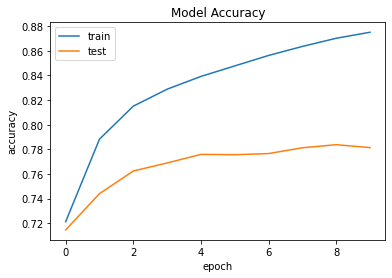

In [114]:
 import matplotlib.pyplot as plt
# %matplotlib inline
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [115]:
encoder_model = Model(encoder_inputs, encoder_states)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.load_weights('seq2seq_eng-fra.h5')

In [116]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [117]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)


In [118]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [119]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

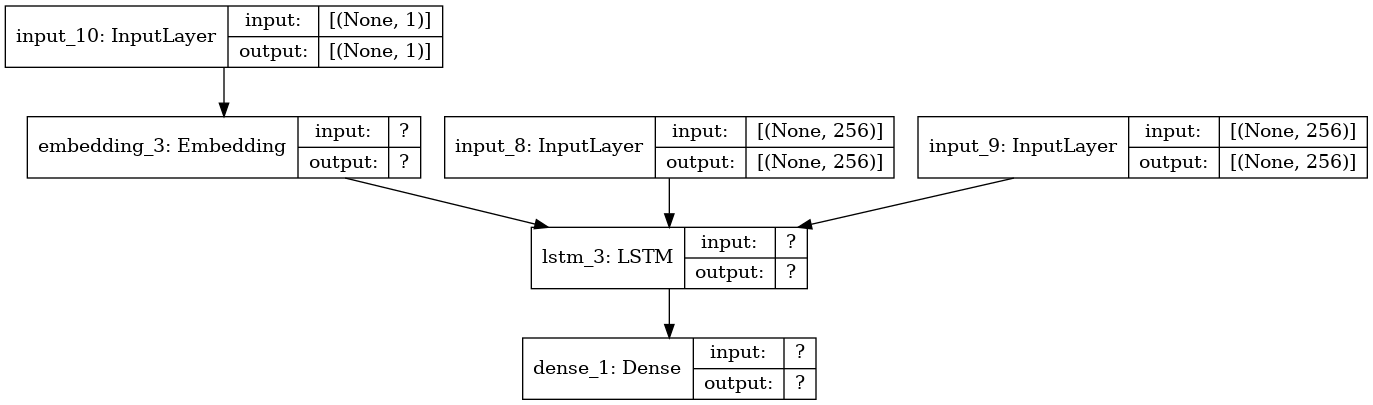

In [120]:
from keras.utils.vis_utils import plot_model
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

# Making Predictions


In [121]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [122]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [123]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ', input_sentences[i])
print('Actual translation : ', output_sentences[i])
print('French translation : ', translation)

Input Language :  Let's go!
Actual translation :  En route ! <eos>
French translation :  en route !
